# Week 5 Homework - Kendall Gilbert

In [18]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box,Point, LineString, Polygon
import geopandas as gpd
import pycrs

### 5.1 Dissolving and Aggregating Data
Let's revisit the dataset from last week, the Justice Equity Need Index (JENI) identifies ZIP Codes in greatest need of public investments in community healing, health, and prevention to help reverse historical injustices. You can access this dataset by navigating to ```data/Justice_Equity_Need_Index.geojson```

Let's start doing some spatial analysis.

1. Load the JENI dataset and view the first few rows. You will notice a column ```sup_dist``` which designates the district number associated with each zip code block. Dissolve by the districts column and use and aggregation function to find the mean ```jenipctl```. 

In [2]:
#load the dataset and view first few rows
JENI_data = gpd.read_file('data/Justice_Equity_Need_Index.geojson')
JENI_data.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/tljh/user/share/proj failed


,OBJECTID,zip,jenicategory,jenipctl,jenirank,riskcategory,riskpctl,driverscategory,driverspctl,systemcategory,systempctl,neighborhood,sup_dist,spa,csa,SHAPE_Length,SHAPE_Area,geometry
0,1,91108,Lowest,0.0,277,Lowest,0.4,Lowest,0.7,Lowest,3.3,San Marino,District 5,SPA 3 - San Gabriel,City of San Marino,0.177419,0.000962,"MULTIPOLYGON (((-118.10864 34.13733, -118.1084..."
1,2,90631,Lowest,0.4,276,Lowest,2.9,Lowest,1.8,Lowest,0.7,La Habra Heights,District 4,SPA 7 - East,City of La Habra Heights,0.234952,0.001614,"MULTIPOLYGON (((-117.94274 33.97488, -117.9427..."
2,3,90274,Lowest,0.7,275,Lowest,3.6,Lowest,0.0,Lowest,7.2,Palos Verdes Estates,District 4,SPA 8 - South Bay,City of Rancho Palos Verdes,0.563332,0.003029,"MULTIPOLYGON (((-118.39057 33.80426, -118.3905..."
3,4,91361,Lowest,1.1,274,Lowest,12.2,Lowest,0.4,Lowest,5.1,Westlake Village,District 3,SPA 2 - San Fernando,City of Westlake Village,0.197748,0.001336,"MULTIPOLYGON (((-118.80028 34.14798, -118.7995..."
4,5,90275,Lowest,1.4,273,Lowest,6.8,Lowest,3.6,Lowest,6.2,Rancho Palos Verdes,District 4,SPA 8 - South Bay,City of Rancho Palos Verdes,0.624171,0.003365,"MULTIPOLYGON (((-118.39313 33.73857, -118.3931..."


In [3]:
#select columns
JENI_distandjenipctl = JENI_data[['sup_dist','jenipctl','geometry']]

#dissolve and aggregate to get mean jenipctl for each district
JENI_data_dissandagg = JENI_distandjenipctl.dissolve(by='sup_dist', aggfunc='mean')
JENI_data_dissandagg

,geometry,jenipctl
sup_dist,,
District 1,"MULTIPOLYGON (((-118.18311 33.99633, -118.1833...",60.502222
District 2,"POLYGON ((-118.37791 33.85345, -118.37791 33.8...",65.157143
District 3,"POLYGON ((-118.52451 34.03052, -118.52502 34.0...",38.586667
District 4,"MULTIPOLYGON (((-118.17124 33.76274, -118.1725...",51.292857
District 5,"POLYGON ((-118.31103 34.10656, -118.31103 34.1...",41.464286


2. Create a map that displays the dissolved dataframe with a lengend showing the districts and the mean ```jenipctl```
3. Write a meaningful caption of the map you have created. Refer back to last week's homework for additional information on what exactly the ```jenipctl``` means.

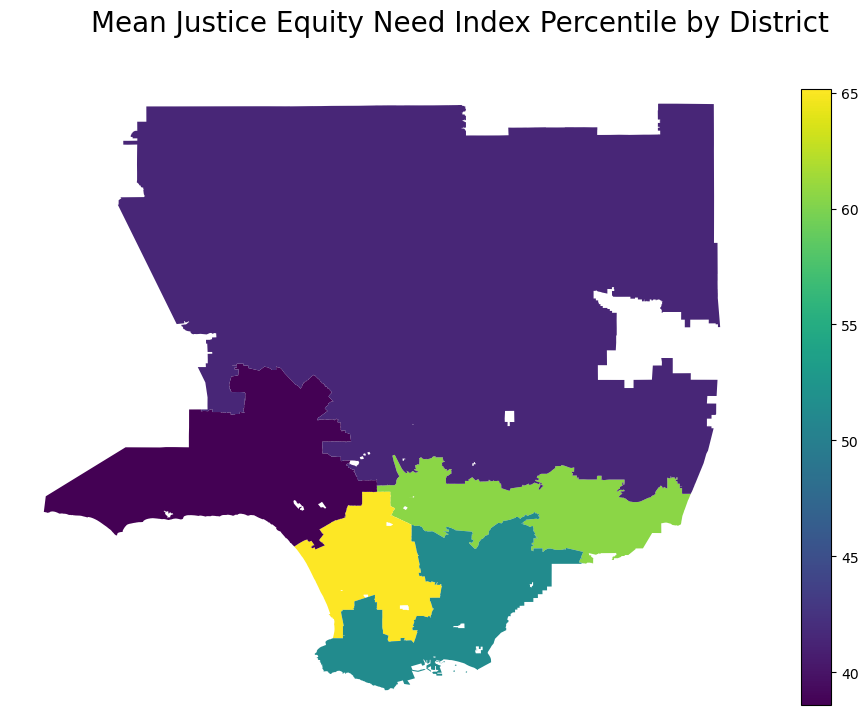

In [76]:
fig, (ax1) = plt.subplots(figsize=(12, 8))

JENI_data_dissandagg.reset_index().plot(column='jenipctl', legend=True, ax=ax1)

plt.suptitle('Mean Justice Equity Need Index Percentile by District', fontsize=20)
leg = ax1.get_legend()
ax1.set_axis_off()
plt.axis('equal')
plt.show()

### 5.2 Spatial Joining
Let's use the same ```data/Justice_Equity_Need_Index.geojson``` and do an analysis just for the neighborhoods within the city of Long Beach. You have been provided two additional datasets. First is the boundary of Long Beach: ```data/LB_City_Boundary.geojson``` and the second is Long Beach neighborhoods: ```data/LB_Neighborhoods.geojson```

1. Clip the original ```data/Justice_Equity_Need_Index.geojson``` by the city of Long Beach boundary. What should you always first check before working with multiple datasets?

The first thing you need to do is load the data and check that the data sets are in the same crs.

In [39]:
#Read in the new data sets
LBcitybound_data = gpd.read_file('data/LB_City_Boundary.geojson')
LBneighborhood_data = gpd.read_file('data/LB_Neighborhoods.geojson')

#Check if both layers in the same CRS
if (LBcitybound_data.crs == JENI_data.crs):
    print("Both layers are in the same crs!",
          LBcitybound_data.crs, JENI_data.crs)

Both layers are in the same crs! epsg:4326 epsg:4326


In [40]:
#Clip the JENI data by the city of Long Beach boundary
JENI_data_clip = gpd.clip(JENI_data,LBcitybound_data)

# Ignore missing/empty geometries
JENI_data_clip = JENI_data_clip[~JENI_data_clip.is_empty]

/opt/tljh/user/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


2. Using the clipped version of the JENI dataset, spatially join the ```data/LB_Neighborhoods.geojson``` and your clipped dataset. 

In [41]:
#Check if both layers in the same CRS
if (LBneighborhood_data.crs == JENI_data_clip.crs):
    print("Both layers are in the same crs!",
          LBneighborhood_data.crs, JENI_data_clip.crs)
    
#Spatially joing the datasets
JENI_data_joined = gpd.sjoin(JENI_data_clip,LBneighborhood_data)
JENI_data_joined.head()

Both layers are in the same crs! epsg:4326 epsg:4326


,OBJECTID_left,zip,jenicategory,jenipctl,jenirank,riskcategory,riskpctl,driverscategory,driverspctl,systemcategory,...,index_right,OBJECTID_right,NEIGHBOR_NAME,GlobalID,created_user,created_date,last_edited_user,last_edited_date,SHAPE_Length_right,SHAPE_Area_right
99,100,90803,Low,35.5,179,High,67.699997,Low,30.1,Low,...,120,121,Unassigned (Entrance Channel),{60ACC1CD-07A1-41AE-B3F3-EC9F37004683},None,NaT,None,NaT,0.009329,0.000005
99,100,90803,Low,35.5,179,High,67.699997,Low,30.1,Low,...,92,93,Peninsula,{C7769C49-526B-486B-AAE7-2313A333FE92},None,NaT,None,NaT,0.043964,0.000048
99,100,90803,Low,35.5,179,High,67.699997,Low,30.1,Low,...,97,98,Unassigned (Alamitos Bay Marina),{070E5177-6B37-4A16-BB0B-2C32BD5C84FF},None,NaT,MEMCNER,2022-07-28 17:37:55+00:00,0.052854,0.000019
99,100,90803,Low,35.5,179,High,67.699997,Low,30.1,Low,...,99,100,Unassigned (Alamitos Bay),{530C569A-F0C3-4BD8-AFC9-4381D010D612},None,NaT,None,NaT,0.104468,0.000095
99,100,90803,Low,35.5,179,High,67.699997,Low,30.1,Low,...,95,96,Unassigned (Los Cerritos Wetlands),{51C34E73-E26C-4BA9-A3E7-1879D33D0570},None,NaT,None,NaT,0.034938,0.000023


3. Make a map that has different color categories for each Long Beach neighborhood by the ```jenipctl```.
4. Write a meaningful caption describing the patterns you see in Long Beach neighorboods ```jenipctl``` rankings. 

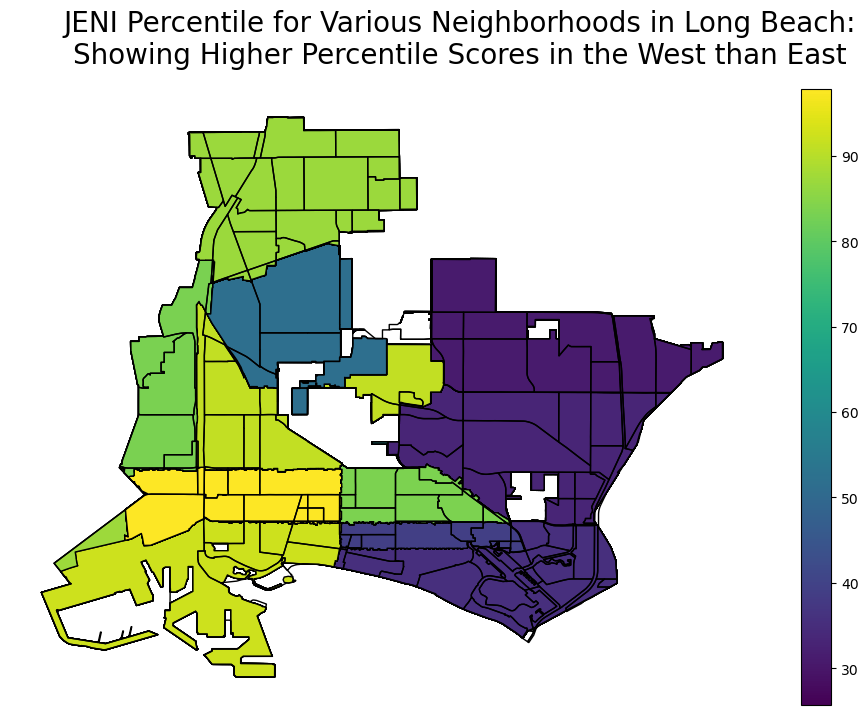

In [75]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

LBneighborhood_data.plot(alpha=1,facecolor="none",edgecolor="black",zorder=10,ax=ax)
JENI_data_joined.plot(column='jenipctl', edgecolor="black", ax=ax, legend=True)

plt.suptitle('JENI Percentile for Various Neighborhoods in Long Beach:\nShowing Higher Percentile Scores in the West than East', fontsize=20)
leg = ax.get_legend()
ax.set_axis_off()
plt.axis('equal')
plt.show()

### 5.3 Calculating Distances
Let's calculate the distance by bird's flight (straight lines) from campus to each zip code. The coordinates of LMU's campus are: 33.9710, -118.4170.

1. The JENI dataset we have been working with has information already grouped by zip code. Load the JENI dataset and select only the ```zip``` and ``` csa ``` columns. 

In [12]:
#Load the zip and csa columns of JENI data and check the selection by printing the first few columns
JENI_zipandcsa = JENI_data[['zip','csa']]
JENI_zipandcsa.head()

,zip,csa
0,91108,City of San Marino
1,90631,City of La Habra Heights
2,90274,City of Rancho Palos Verdes
3,91361,City of Westlake Village
4,90275,City of Rancho Palos Verdes


2. Create the point for LMU's campus assuming the CRS to be ```epsg:4326```. Reproject this point to ```epsg:3857```.

In [22]:
#Set coordinates for LMU
LMU_lon = -118.4170
LMU_lat = 33.9710

#Create geodataframe for point of LMU campus
LMU_campus = gpd.GeoDataFrame([[Point(LMU_lon, LMU_lat)]], geometry='geometry', crs={'init': 'epsg:4326'}, columns=['geometry'])

#Reproject the point to epsg 3857
LMU_campus = LMU_campus.to_crs(epsg=3857)
LMU_campus

/opt/tljh/user/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry
0,POINT (-13182120.141 4024908.699)


3. Find the centroids of the zip code and city name dataframe (the subset from the JENI dataframe). Did you receive a warning? What should you do?

In [28]:
#Reproject JENI data to same epsg as LMU campus
JENI_data_reprojected = JENI_data.to_crs(epsg=3857)

#Find the centroids of the zip code and city name dataframe and print first few rows with new centroid column
JENI_zipandcsa['Centroids'] = JENI_data_reprojected.centroid
JENI_zipandcsa.head()

/tmp/ipykernel_110700/522851142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JENI_zipandcsa['Centroids'] = JENI_data_reprojected.centroid


,zip,csa,Centroids
0,91108,City of San Marino,POINT (-13148349.834 4045245.070)
1,90631,City of La Habra Heights,POINT (-13130220.945 4023406.404)
2,90274,City of Rancho Palos Verdes,POINT (-13176716.971 3998944.034)
3,91361,City of Westlake Village,POINT (-13228375.469 4046330.223)
4,90275,City of Rancho Palos Verdes,POINT (-13176234.604 3996054.498)


Yes I received a warning that the data was in a geographic CRS so the centroid was likely incorrect. To not receive this warning I altered my code to first reproject the data to a projected CRS.

4. Using the following function, calculate the distance from the LMU campus to each zip code. 

In [29]:
def calculate_distance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
       A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
       A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
       A name of the target column where the result will be stored.

    Returns
    -------
    
    Distance in kilometers that will be stored in 'target_col'.
    """
    
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)

    # Convert into kilometers
    dist_km = dist / 1000

    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

In [34]:
# Calculate the distances from LMU campus using the function and print first few rows to check
JENI_zipandcsa = JENI_zipandcsa.apply(calculate_distance, dest_geom=LMU_campus.loc[0,'geometry'], src_col='Centroids', target_col='Distance to LMU Campus', axis=1)
JENI_zipandcsa.head()

,zip,csa,Centroids,Distance to LMU Campus
0,91108,City of San Marino,POINT (-13148349.833923832 4045245.069634103),39.420827
1,90631,City of La Habra Heights,POINT (-13130220.944533523 4023406.403868277),51.920935
2,90274,City of Rancho Palos Verdes,POINT (-13176716.97135462 3998944.034374197),26.520898
3,91361,City of Westlake Village,POINT (-13228375.469475666 4046330.222516783),50.974867
4,90275,City of Rancho Palos Verdes,POINT (-13176234.603574079 3996054.497534473),29.448336


5. What is the maximum distance from the LMU campus? Which zip code does this pertain to? What is the average distace to the LMU campus?

In [37]:
#Calculate and print the maximum distance
max_dist = JENI_zipandcsa['Distance to LMU Campus'].max()
print('The maximum distance from the LMU campus is',max_dist)

#Find the zip code that has the maximum distance and print it
for i in range(len(JENI_zipandcsa)):
    if JENI_zipandcsa.loc[i,'Distance to LMU Campus'] == max_dist:
        print('The zip code pertaining to the maximum distance is',JENI_zipandcsa.loc[i,'zip'])

#Calculate and print the average distance to the LMU campus
print('The average distance to the LMU campus is', JENI_zipandcsa['Distance to LMU Campus'].mean())

The maximum distance from the LMU campus is 116.81155197091826
The zip code pertaining to the maximum distance is 93535
The average distance to the LMU campus is 35.3095243272912
